# Sensor Data Analysis

Analyse "Bag of sensors" data from PhysioNet: https://physionet.org/physiobank/database/noneeg/

Under/Oversampling

Feature Extraction
- Statistical
- Spectral
- Smoothing

Machine Learning

## Data Introduction

## Load Data

Each subject has several datafiles:
- SubjectN_AccTempEDA.atr: annotation
- SubjectN_AccTempEDA.dat: data
- SubjectN_AccTempEDA.hea: header
- SubjectN_Sp02HR.dat: data
- SubjectN_Sp02HR.hea: header

These files are in the WFDB (WaveForm DataBase) format, and can be read using the `wfdb` python module.
(https://github.com/MIT-LCP/wfdb-python)

https://www.physionet.org/standards/npsg/Moody.pdf

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from scipy import fftpack, signal

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

sns.set() # style

# pip install wfdb
import wfdb

# render plots inline
%matplotlib inline

### Acc Temp EDA

In [2]:
ann = wfdb.rdann('./data/physionet/Subject10_AccTempEDA', extension='atr', summarize_labels=True)
print(ann.__dict__)

{'record_name': 'Subject10_AccTempEDA', 'extension': 'atr', 'sample': array([    1,  2401,  5010,  7411,  7732, 10573, 12974, 15839]), 'symbol': ['"', '"', '"', '"', '"', '"', '"', '"'], 'subtype': array([0, 0, 0, 0, 0, 0, 0, 0]), 'chan': array([0, 0, 0, 0, 0, 0, 0, 0]), 'num': array([0, 0, 0, 0, 0, 0, 0, 0]), 'aux_note': ['Relax', 'PhysicalStress', 'Relax', 'EmotionalStress', 'CognitiveStress', 'Relax', 'EmotionalStress', 'Relax'], 'fs': 8, 'label_store': None, 'description': None, 'custom_labels': None, 'contained_labels':     label_store symbol         description
22           22      "  Comment annotation, 'ann_len': 8}


{'record_name': 'Subject10_AccTempEDA', 'n_sig': 5, 'fs': 8, 'counter_freq': None, 'base_counter': None, 'sig_len': 18239, 'base_time': None, 'base_date': None, 'comments': ['age: 23', 'gender: M', 'height/cm: 180', 'weight/kg: 64'], 'sig_name': ['ax', 'ay', 'az', 'temp', 'EDA'], 'p_signal': array([[ 4.49967956e-01, -1.00996857e+00, -4.00036622e-02,
         2.70000641e+01,  3.25101413e+00],
       [ 4.39992676e-01, -1.01998718e+00, -4.00036622e-02,
         2.70000641e+01,  3.25605237e+00],
       [ 4.49967956e-01, -1.01998718e+00, -5.00045778e-02,
         2.70000641e+01,  3.25605237e+00],
       ...,
       [ 8.79985351e-01, -7.49980163e-01, -2.00018311e-02,
         3.34999664e+01,  6.22591473e+00],
       [ 8.79985351e-01, -7.49980163e-01, -2.00018311e-02,
         3.34999664e+01,  6.22591473e+00],
       [ 8.79985351e-01, -7.49980163e-01, -2.00018311e-02,
         3.34999664e+01,  6.22591473e+00]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['Subject1

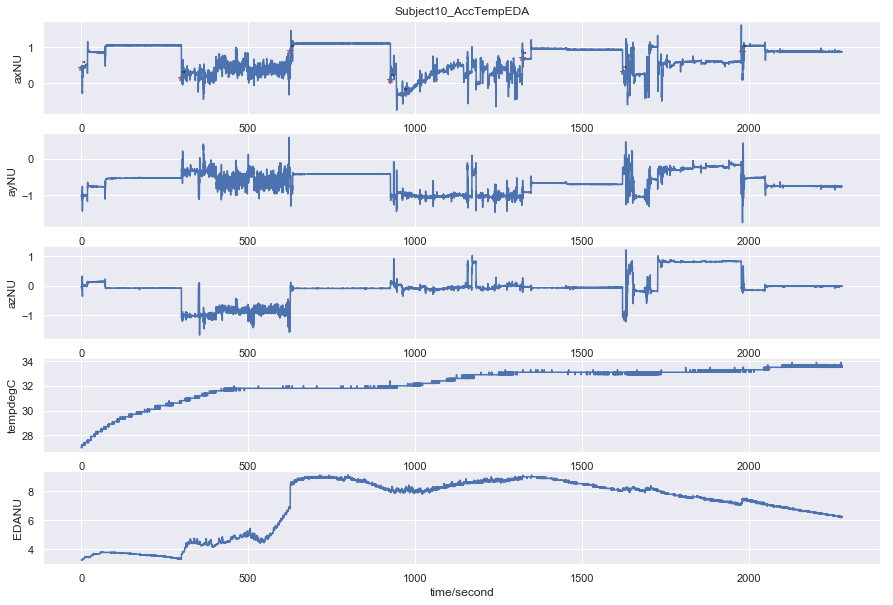

In [3]:
record_acc_temp_eda = wfdb.rdrecord('./data/physionet/Subject10_AccTempEDA')
print(record_acc_temp_eda.__dict__)

wfdb.plot_wfdb(record=record_acc_temp_eda, title='Subject10_AccTempEDA', annotation=ann, plot_sym=True, 
               time_units='seconds', figsize=(15, 10))

In [4]:
data_acc_temp_eda = record_acc_temp_eda.p_signal
data_acc_temp_eda.shape

(18239, 5)

### SpO2 HR

{'record_name': 'Subject10_SpO2HR', 'n_sig': 2, 'fs': 1, 'counter_freq': None, 'base_counter': None, 'sig_len': 2286, 'base_time': None, 'base_date': None, 'comments': ['age: 23', 'gender: M', 'height/cm: 180', 'weight/kg: 64'], 'sig_name': ['SpO2', 'hr'], 'p_signal': array([[96.99995422, 95.99990844],
       [95.99993896, 95.99990844],
       [95.99993896, 96.9999237 ],
       ...,
       [95.99993896, 69.00027467],
       [95.99993896, 68.00025941],
       [95.99993896, 67.00024415]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['Subject10_SpO2HR.dat', 'Subject10_SpO2HR.dat'], 'fmt': ['16', '16'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [13106.8, 1284.98039216], 'baseline': [-1251699, -112435], 'units': ['%', 'bpm'], 'adc_res': [16, 16], 'adc_zero': [0, 0], 'init_value': [19660, 10923], 'checksum': [39424, 34156], 'block_size': [0, 0]}


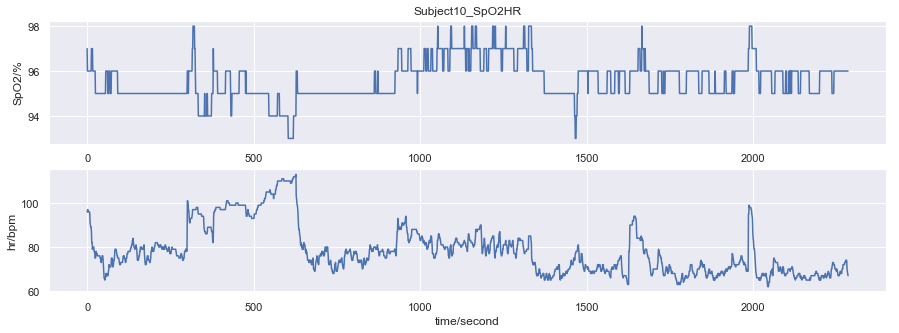

In [5]:
record_spo2_hr = wfdb.rdrecord('./data/physionet/Subject10_SpO2HR')
print(record_spo2_hr.__dict__)

wfdb.plot_wfdb(record=record_spo2_hr, title='Subject10_SpO2HR', time_units='seconds', figsize=(15, 5))

In [6]:
data_spo2_hr = record_spo2_hr.p_signal
data_spo2_hr.shape

(2286, 2)

In [7]:
# number of acceleration, etc samples per second
record_acc_temp_eda.fs

8

In [8]:
# number of SpO2 and HR samples per second
record_spo2_hr.fs

1

## Aligning data of different frequencies

The two dataset frequencies (number of samples per second) are different.

To support processing both datasets at the same time, we need to match the frequencies.

This is a common situation when taking readings from different sensors or data sources.

Two strategies:
1. Upsampling the smaller frequency data. E.g: repeat samples or interpolate.
2. Downsampling the larger frequency data. E.g: replace with mean or median.

Which one to pick depends on requirements: whether you need to maintain precision of the higher frequency dataset.

Example: https://machinelearningmastery.com/resample-interpolate-time-series-data-python/

### Option 1: Upsampling SpO2 HR to 8 samples per second

In [9]:
# create an index with 1 second timestamps, using the length of data_spo2_hr
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.period_range.html
#
# frequency strings: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

# for this dataset, the start date is just an arbitrary reference
per_second_index = pd.period_range(start='2019-01-01', periods=len(data_spo2_hr), freq='S')
per_second_index

PeriodIndex(['2019-01-01 00:00:00', '2019-01-01 00:00:01',
             '2019-01-01 00:00:02', '2019-01-01 00:00:03',
             '2019-01-01 00:00:04', '2019-01-01 00:00:05',
             '2019-01-01 00:00:06', '2019-01-01 00:00:07',
             '2019-01-01 00:00:08', '2019-01-01 00:00:09',
             ...
             '2019-01-01 00:37:56', '2019-01-01 00:37:57',
             '2019-01-01 00:37:58', '2019-01-01 00:37:59',
             '2019-01-01 00:38:00', '2019-01-01 00:38:01',
             '2019-01-01 00:38:02', '2019-01-01 00:38:03',
             '2019-01-01 00:38:04', '2019-01-01 00:38:05'],
            dtype='period[S]', length=2286, freq='S')

In [10]:
# create a dataframe for SpO2 data using the above period index
df_spO2_hr = pd.DataFrame(data_spo2_hr, index=per_second_index, columns=record_spo2_hr.sig_name)
df_spO2_hr.head()

,SpO2,hr
2019-01-01 00:00:00,96.999954,95.999908
2019-01-01 00:00:01,95.999939,95.999908
2019-01-01 00:00:02,95.999939,96.999924
2019-01-01 00:00:03,95.999939,95.999908
2019-01-01 00:00:04,95.999939,95.999908


In [11]:
# upsample to match the frequency of the other data (8 times)

In [12]:
samples_per_sec = record_acc_temp_eda.fs // record_spo2_hr.fs # // converts float to int (ceiling)
samples_per_sec

8

In [13]:
# resample, then interpolate
# Note: whether interpolation makes sense depends on the sensor and type of data
upsampled = df_spO2_hr.resample('125ms')

df_upsampled = upsampled.interpolate()
df_upsampled.head(10)

,SpO2,hr
2019-01-01 00:00:00.000,96.999954,95.999908
2019-01-01 00:00:00.125,96.874952,95.999908
2019-01-01 00:00:00.250,96.749950,95.999908
2019-01-01 00:00:00.375,96.624949,95.999908
2019-01-01 00:00:00.500,96.499947,95.999908
2019-01-01 00:00:00.625,96.374945,95.999908
2019-01-01 00:00:00.750,96.249943,95.999908
2019-01-01 00:00:00.875,96.124941,95.999908
2019-01-01 00:00:01.000,95.999939,95.999908
2019-01-01 00:00:01.125,95.999939,96.124910


In [14]:
df_upsampled.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 18288 entries, 2019-01-01 00:00:00.000 to 2019-01-01 00:38:05.875
Freq: 125L
Data columns (total 2 columns):
SpO2    18288 non-null float64
hr      18288 non-null float64
dtypes: float64(2)
memory usage: 428.6 KB


In [15]:
# Note: there are fewer values in the Acc dataframe, so we need to ignore the
# later entries from df_upsampled.

df_acc_temp_eda = pd.DataFrame(data_acc_temp_eda, columns=record_acc_temp_eda.sig_name)
df_acc_temp_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18239 entries, 0 to 18238
Data columns (total 5 columns):
ax      18239 non-null float64
ay      18239 non-null float64
az      18239 non-null float64
temp    18239 non-null float64
EDA     18239 non-null float64
dtypes: float64(5)
memory usage: 712.5 KB


In [16]:
df_acc_temp_eda.index = df_upsampled.index[:len(df_acc_temp_eda)]
df_acc_temp_eda.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 18239 entries, 2019-01-01 00:00:00.000 to 2019-01-01 00:37:59.750
Freq: 125L
Data columns (total 5 columns):
ax      18239 non-null float64
ay      18239 non-null float64
az      18239 non-null float64
temp    18239 non-null float64
EDA     18239 non-null float64
dtypes: float64(5)
memory usage: 855.0 KB


In [17]:
# concatenate the two dataframes, column-wise
df_option1 = pd.concat([df_acc_temp_eda, df_upsampled], axis=1).dropna()
df_option1.head()

,ax,ay,az,temp,EDA,SpO2,hr
2019-01-01 00:00:00.000,0.449968,-1.009969,-0.040004,27.000064,3.251014,96.999954,95.999908
2019-01-01 00:00:00.125,0.439993,-1.019987,-0.040004,27.000064,3.256052,96.874952,95.999908
2019-01-01 00:00:00.250,0.449968,-1.019987,-0.050005,27.000064,3.256052,96.749950,95.999908
2019-01-01 00:00:00.375,0.449968,-1.009969,-0.040004,27.000064,3.256052,96.624949,95.999908
2019-01-01 00:00:00.500,0.439993,-1.009969,-0.050005,27.000064,3.256052,96.499947,95.999908


In [18]:
df_option1.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 18239 entries, 2019-01-01 00:00:00.000 to 2019-01-01 00:37:59.750
Freq: 125L
Data columns (total 7 columns):
ax      18239 non-null float64
ay      18239 non-null float64
az      18239 non-null float64
temp    18239 non-null float64
EDA     18239 non-null float64
SpO2    18239 non-null float64
hr      18239 non-null float64
dtypes: float64(7)
memory usage: 1.1 MB


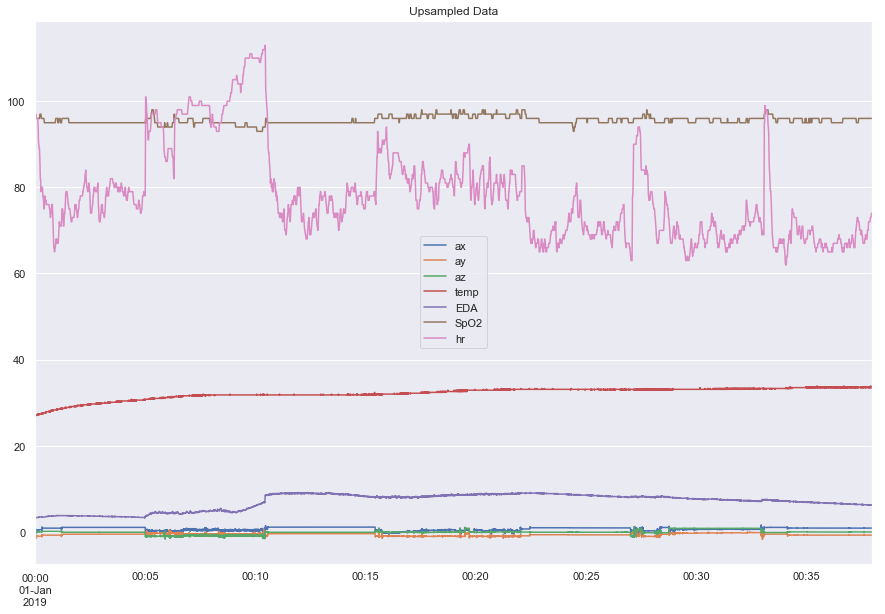

In [19]:
# https://stackoverflow.com/questions/48126330/python-int-too-large-to-convert-to-c-long-plotting-pandas-dates
df_option1.index = pd.to_datetime(df_option1.index.to_timestamp())

df_option1.plot(figsize=(15, 10))
ax = plt.gca()
ax.set_title('Upsampled Data')
plt.show()

In [20]:
df_option1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18239 entries, 2019-01-01 00:00:00 to 2019-01-01 00:37:59.750000
Freq: 125L
Data columns (total 7 columns):
ax      18239 non-null float64
ay      18239 non-null float64
az      18239 non-null float64
temp    18239 non-null float64
EDA     18239 non-null float64
SpO2    18239 non-null float64
hr      18239 non-null float64
dtypes: float64(7)
memory usage: 1.1 MB


### Option 2: Downsampling Acc Temp EDA to 1 sample per second

In [21]:
# create an index with 125 millisecond timestamps, using the length of data_acc_temp_eda
#
# frequency strings: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

# for this dataset, the start date is just an arbitrary reference
per_125_ms_index = pd.period_range(start='2019-01-01', periods=len(data_acc_temp_eda), freq='125ms')
per_125_ms_index

PeriodIndex(['2019-01-01 00:00:00.000', '2019-01-01 00:00:00.125',
             '2019-01-01 00:00:00.250', '2019-01-01 00:00:00.375',
             '2019-01-01 00:00:00.500', '2019-01-01 00:00:00.625',
             '2019-01-01 00:00:00.750', '2019-01-01 00:00:00.875',
             '2019-01-01 00:00:01.000', '2019-01-01 00:00:01.125',
             ...
             '2019-01-01 00:37:58.625', '2019-01-01 00:37:58.750',
             '2019-01-01 00:37:58.875', '2019-01-01 00:37:59.000',
             '2019-01-01 00:37:59.125', '2019-01-01 00:37:59.250',
             '2019-01-01 00:37:59.375', '2019-01-01 00:37:59.500',
             '2019-01-01 00:37:59.625', '2019-01-01 00:37:59.750'],
            dtype='period[125L]', length=18239, freq='125L')

In [22]:
# create a dataframe for Acc Temp EDA using the 125ms period index
df_acc_temp_eda2 = pd.DataFrame(data_acc_temp_eda, index=per_125_ms_index, columns=record_acc_temp_eda.sig_name)
df_acc_temp_eda2.head()

,ax,ay,az,temp,EDA
2019-01-01 00:00:00.000,0.449968,-1.009969,-0.040004,27.000064,3.251014
2019-01-01 00:00:00.125,0.439993,-1.019987,-0.040004,27.000064,3.256052
2019-01-01 00:00:00.250,0.449968,-1.019987,-0.050005,27.000064,3.256052
2019-01-01 00:00:00.375,0.449968,-1.009969,-0.040004,27.000064,3.256052
2019-01-01 00:00:00.500,0.439993,-1.009969,-0.050005,27.000064,3.256052


In [23]:
# downsample using median
df_acc_temp_eda_downsampled = df_acc_temp_eda2.resample('S').median()
df_acc_temp_eda_downsampled.head(10)

,ax,ay,az,temp,EDA
2019-01-01 00:00:00,0.449968,-1.009969,-0.045004,27.000064,3.256052
2019-01-01 00:00:01,0.439993,-1.009969,-0.040004,27.200008,3.256052
2019-01-01 00:00:02,0.385021,-1.034980,0.144969,27.200008,3.267568
2019-01-01 00:00:03,-0.154977,-0.984975,0.104965,27.200008,3.279084
2019-01-01 00:00:04,0.215027,-1.039989,0.009957,27.200008,3.336034
2019-01-01 00:00:05,0.419988,-1.009969,0.004978,27.200008,3.336034
2019-01-01 00:00:06,0.459979,-0.999985,0.000000,27.200008,3.342062
2019-01-01 00:00:07,0.479966,-0.999985,0.000000,27.200008,3.342062
2019-01-01 00:00:08,0.489977,-0.999985,0.000000,27.200008,3.342062
2019-01-01 00:00:09,0.489977,-0.999985,0.000000,27.200008,3.395054


In [24]:
df_acc_temp_eda_downsampled.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 2280 entries, 2019-01-01 00:00:00 to 2019-01-01 00:37:59
Freq: S
Data columns (total 5 columns):
ax      2280 non-null float64
ay      2280 non-null float64
az      2280 non-null float64
temp    2280 non-null float64
EDA     2280 non-null float64
dtypes: float64(5)
memory usage: 106.9 KB


In [25]:
df_spo2_hr2 = pd.DataFrame(data_spo2_hr, columns=record_spo2_hr.sig_name, index=per_second_index)
df_spo2_hr2.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 2286 entries, 2019-01-01 00:00:00 to 2019-01-01 00:38:05
Freq: S
Data columns (total 2 columns):
SpO2    2286 non-null float64
hr      2286 non-null float64
dtypes: float64(2)
memory usage: 53.6 KB


In [26]:
# concatenate the two dataframes, column-wise
df_option2 = pd.concat([df_acc_temp_eda_downsampled, df_spo2_hr2], axis=1).dropna()
df_option2.head()

,ax,ay,az,temp,EDA,SpO2,hr
2019-01-01 00:00:00,0.449968,-1.009969,-0.045004,27.000064,3.256052,96.999954,95.999908
2019-01-01 00:00:01,0.439993,-1.009969,-0.040004,27.200008,3.256052,95.999939,95.999908
2019-01-01 00:00:02,0.385021,-1.034980,0.144969,27.200008,3.267568,95.999939,96.999924
2019-01-01 00:00:03,-0.154977,-0.984975,0.104965,27.200008,3.279084,95.999939,95.999908
2019-01-01 00:00:04,0.215027,-1.039989,0.009957,27.200008,3.336034,95.999939,95.999908


In [27]:
df_option2.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 2280 entries, 2019-01-01 00:00:00 to 2019-01-01 00:37:59
Freq: S
Data columns (total 7 columns):
ax      2280 non-null float64
ay      2280 non-null float64
az      2280 non-null float64
temp    2280 non-null float64
EDA     2280 non-null float64
SpO2    2280 non-null float64
hr      2280 non-null float64
dtypes: float64(7)
memory usage: 142.5 KB


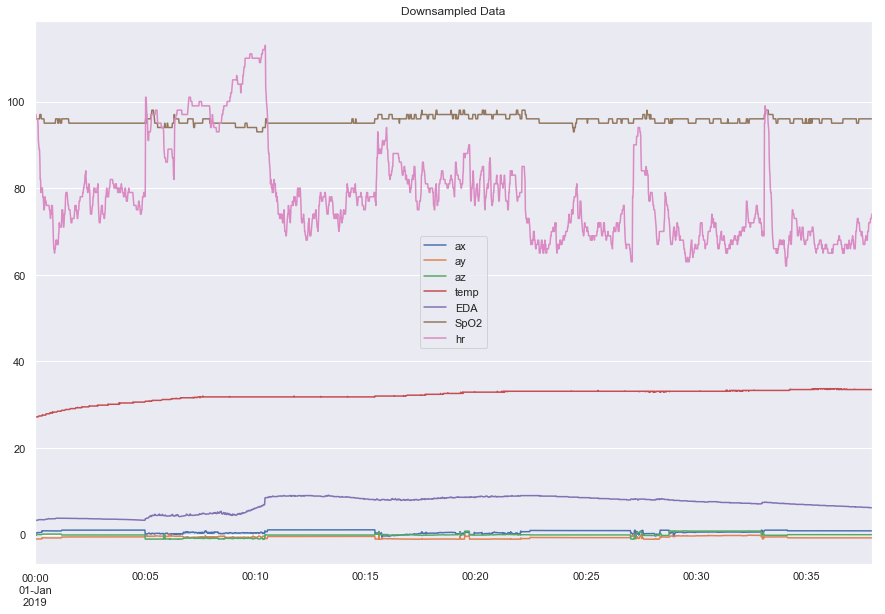

In [28]:
# Not needed, but for consistency with df_option1
df_option2.index = pd.to_datetime(df_option2.index.to_timestamp())

df_option2.plot(figsize=(15, 10))
ax = plt.gca()
ax.set_title('Downsampled Data')
plt.show()

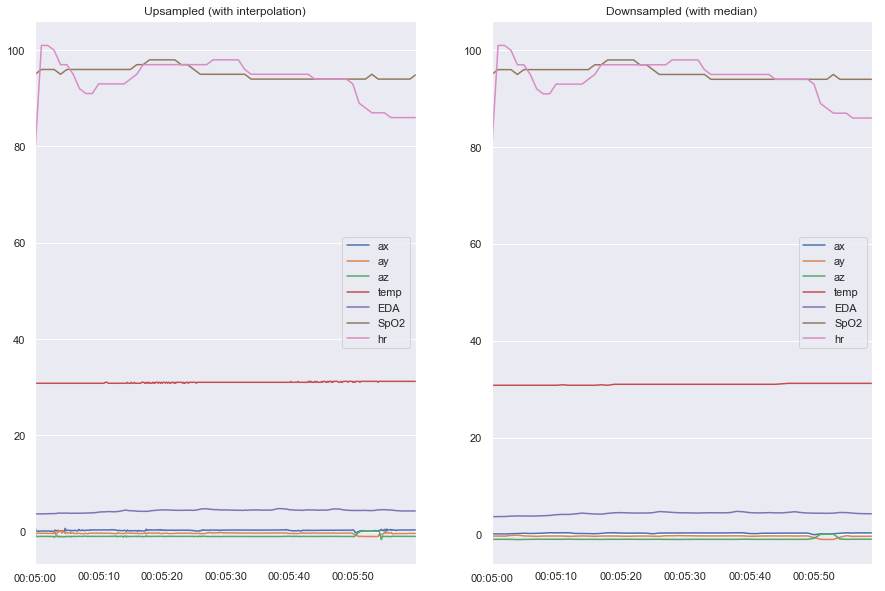

In [29]:
# Let's zoom into a 1-second time window and compare the plots

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
start_time = '2019-01-01 00:05'
end_time = '2019-01-01 00:06'

df_option1[(df_option1.index >= start_time) & (df_option1.index < end_time)].plot(ax=ax1)
ax1.set_title('Upsampled (with interpolation)')
df_option2[(df_option2.index >= start_time) & (df_option2.index < end_time)].plot(ax=ax2)
ax2.set_title('Downsampled (with median)')
plt.show()

## Statistical Features

- Mean, median, standard deviation
- Quantisation / discretisation
- Correlation
- Auto-correlation

In [30]:
df = df_option1

In [31]:
df.mean() # mean of each column

ax       0.692899
ay      -0.624442
az      -0.079151
temp    32.179924
EDA      7.020280
SpO2    95.587481
hr      78.470389
dtype: float64

In [32]:
df.median() # median is less sensitive to outliers than mean

ax       0.869974
ay      -0.639988
az      -0.080007
temp    32.599957
EDA      7.809991
SpO2    95.249985
hr      76.125383
dtype: float64

In [33]:
df.std() # standard deviation

ax       0.365214
ay       0.259942
az       0.451252
temp     1.336794
EDA      1.876670
SpO2     0.855413
hr      11.066407
dtype: float64

In [34]:
df.max()

ax        1.619993
ay        0.579982
az        1.219979
temp     33.899959
EDA       9.146924
SpO2     97.999969
hr      112.999390
dtype: float64

In [35]:
df.min()

ax      -0.739971
ay      -1.739982
az      -1.679977
temp    27.000064
EDA      3.251014
SpO2    93.000046
hr      62.000168
dtype: float64

In [36]:
df.columns

Index(['ax', 'ay', 'az', 'temp', 'EDA', 'SpO2', 'hr'], dtype='object')

### Discretise into quantiles

Discretisation is useful when there is a lot of noise in the signal.

https://datascience.stackexchange.com/questions/19782/what-is-the-rationale-for-discretization-of-continuous-features-and-when-should

In [37]:
df.ax.values.ravel() # raw values

array([0.44996796, 0.43999268, 0.44996796, ..., 0.87998535, 0.87998535,
       0.87998535])

In [38]:
df['ax_q10'] = pd.qcut(df.ax.values.ravel(), 10, labels=False, duplicates='drop')

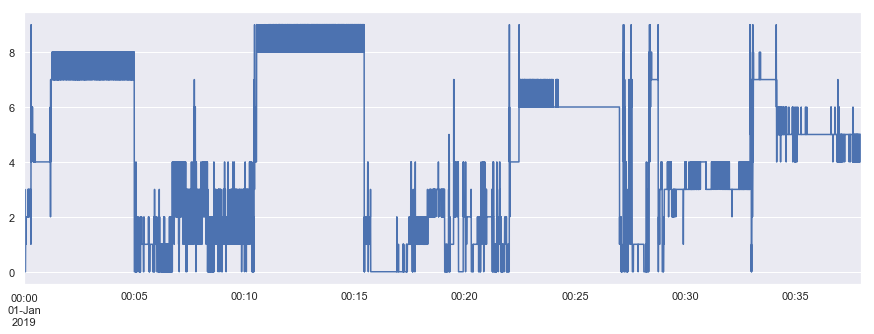

In [39]:
fig, ax = plt.subplots(figsize=(15, 5))
df['ax_q10'].plot(ax=ax)
plt.show()

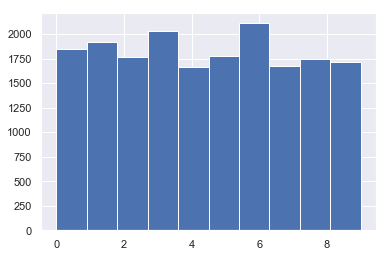

In [40]:
# histogram showing distribution in the 10 levels
# Note: a histogram best applies to discrete variables
df['ax_q10'].hist()

In [41]:
df['ay_q10'] = pd.qcut(df.ay.values.ravel(), 10, labels=False, duplicates='drop')
df['az_q10'] = pd.qcut(df.az.values.ravel(), 10, labels=False, duplicates='drop')

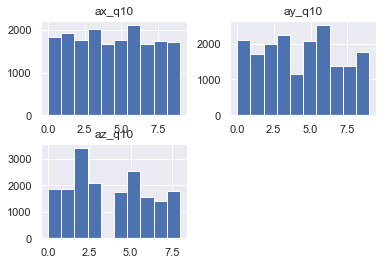

In [42]:
# Plotting multiple histograms
df.loc[:, ['ax_q10', 'ay_q10', 'az_q10']].hist()
plt.show()

### Pair-plot

Pair plots are a combination of scatter plots and histograms. 

They are done for each pair of features (e.g. ax vs. ay)

https://seaborn.pydata.org/generated/seaborn.pairplot.html

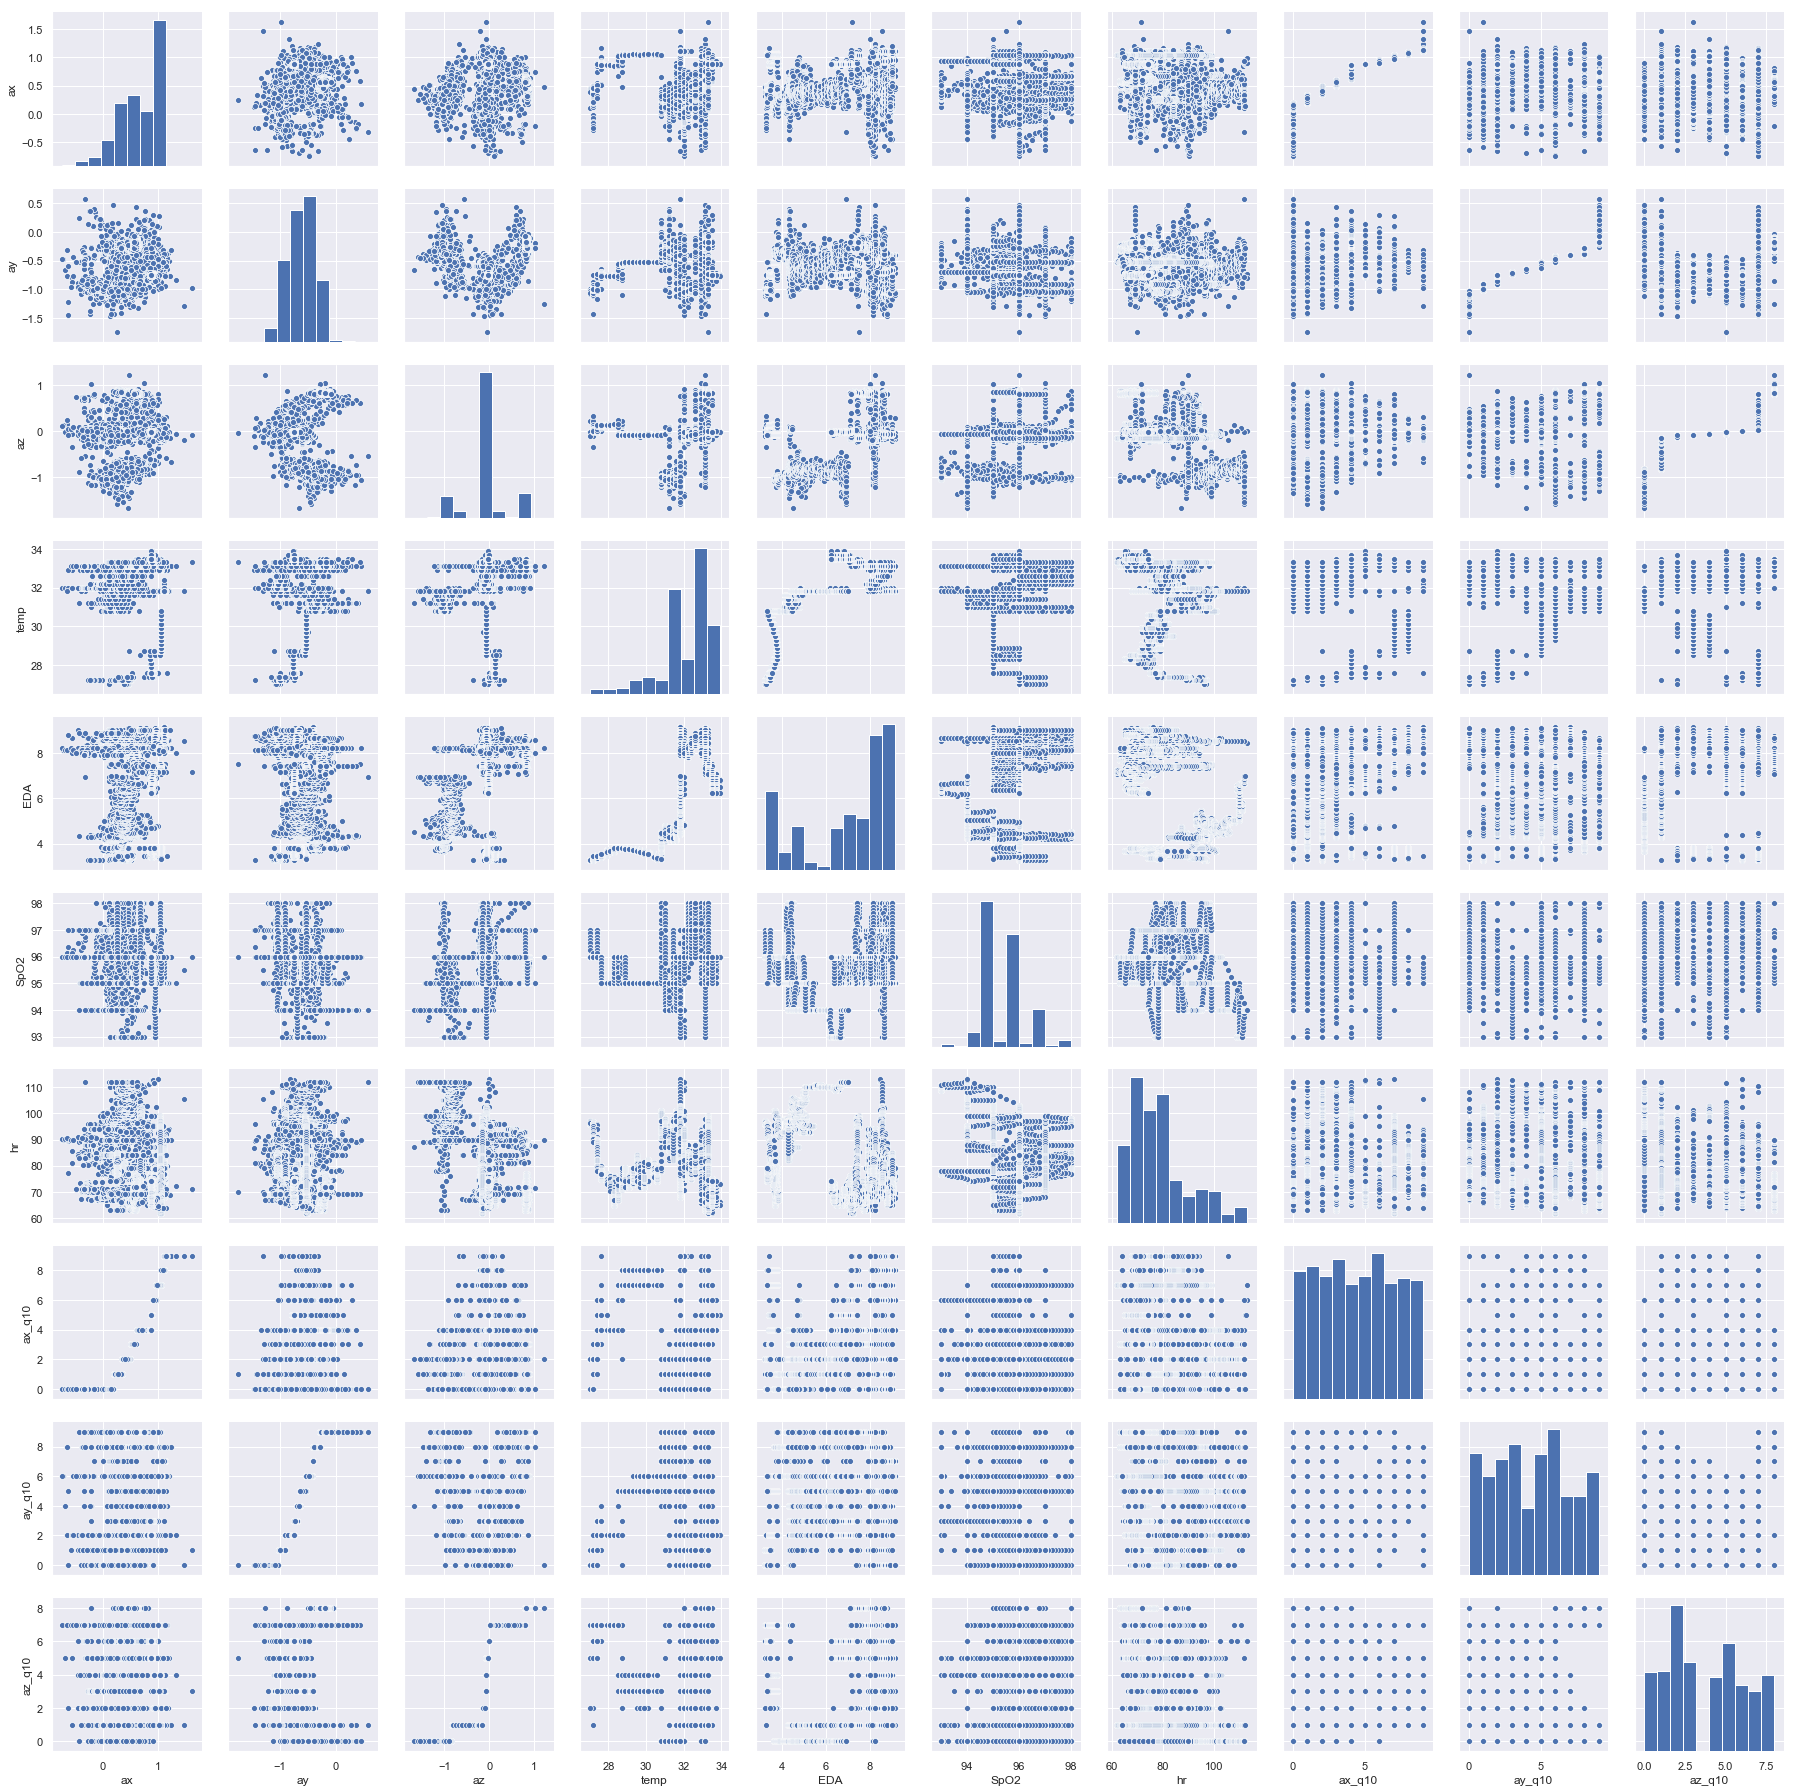

In [43]:
sns.pairplot(df)

### Correlation

Correlations provide a metric to indicate whether two variables are strongly dependent.

https://www.statisticssolutions.com/correlation-pearson-kendall-spearman/

In [44]:
df.corr(method='pearson')

,ax,ay,az,temp,EDA,SpO2,hr,ax_q10,ay_q10,az_q10
ax,1.000000,0.362244,0.170707,-0.110856,-0.018944,-0.298530,-0.473594,0.954295,0.294335,0.011857
ay,0.362244,1.000000,0.159515,-0.077881,-0.186343,-0.479444,-0.081967,0.383866,0.979013,-0.001496
az,0.170707,0.159515,1.000000,0.264251,0.352114,0.246086,-0.661918,0.155289,0.154782,0.844994
temp,-0.110856,-0.077881,0.264251,1.000000,0.695196,0.275015,-0.311503,-0.152813,-0.080247,0.255356
EDA,-0.018944,-0.186343,0.352114,0.695196,1.000000,0.324747,-0.344800,0.042475,-0.168119,0.201379
SpO2,-0.298530,-0.479444,0.246086,0.275015,0.324747,1.000000,-0.113245,-0.324283,-0.447601,0.250082
hr,-0.473594,-0.081967,-0.661918,-0.311503,-0.344800,-0.113245,1.000000,-0.433978,-0.040644,-0.543761
ax_q10,0.954295,0.383866,0.155289,-0.152813,0.042475,-0.324283,-0.433978,1.000000,0.328862,-0.069306
ay_q10,0.294335,0.979013,0.154782,-0.080247,-0.168119,-0.447601,-0.040644,0.328862,1.000000,-0.025101
az_q10,0.011857,-0.001496,0.844994,0.255356,0.201379,0.250082,-0.543761,-0.069306,-0.025101,1.000000


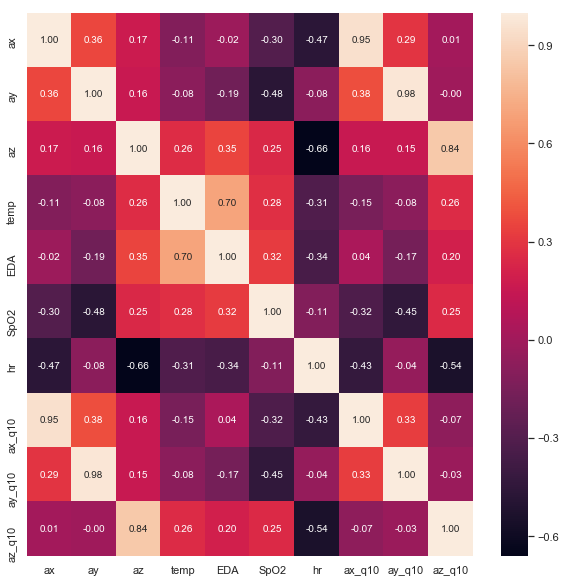

In [45]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(method='pearson'), annot=True, fmt='.2f')
plt.show()

### Auto-correlation

Runs correlation on progressive longer time steps (lags)

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

The Pearson’s correlation coefficient is a number between -1 and 1 that describes a negative or positive correlation respectively. A value of zero indicates no correlation.

We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.

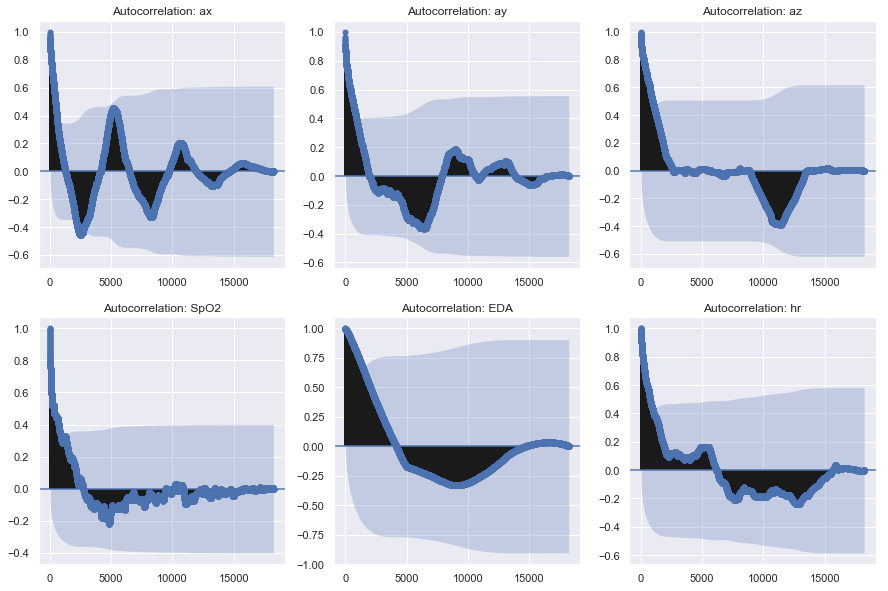

In [46]:
columns = ['ax', 'ay', 'az', 'SpO2', 'EDA', 'hr']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for ax, c in zip(axes, columns):
    plot_acf(df[c], ax=ax)
    ax.set_title(f'Autocorrelation: {c}')

plt.show()

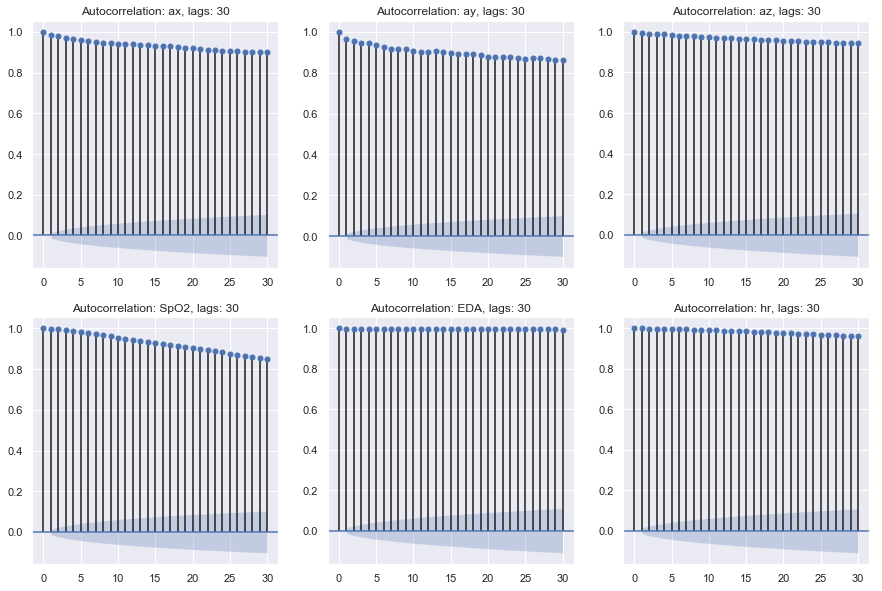

In [47]:
lags = 30

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()
for ax, c in zip(axes, columns):
    plot_acf(df[c], ax=ax, lags=lags)
    ax.set_title(f'Autocorrelation: {c}, lags: {lags}')

plt.show()

## Spectal Features

FFT: 

https://ipython-books.github.io/101-analyzing-the-frequency-components-of-a-signal-with-a-fast-fourier-transform/

http://scipy-lectures.org/intro/scipy/auto_examples/plot_fftpack.html#sphx-glr-intro-scipy-auto-examples-plot-fftpack-py

In [48]:
# Alternative way to compute power spectral density
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html

def power_spectral_density(x):
    psd = np.abs(x) ** 2
    return 20 * np.log10(psd / psd.max()) # decibels

In [49]:
# fft of some signals
fft_ax = fftpack.fft(df.ax)
fft_hr = fftpack.fft(df.hr)
fft_eda = fftpack.fft(df.EDA)

psd_ax = power_spectral_density(fft_ax)
psd_hr = power_spectral_density(fft_hr)
psd_eda = power_spectral_density(fft_eda)

sample_freq = fftpack.fftfreq(len(df.ax), d=1./samples_per_sec)

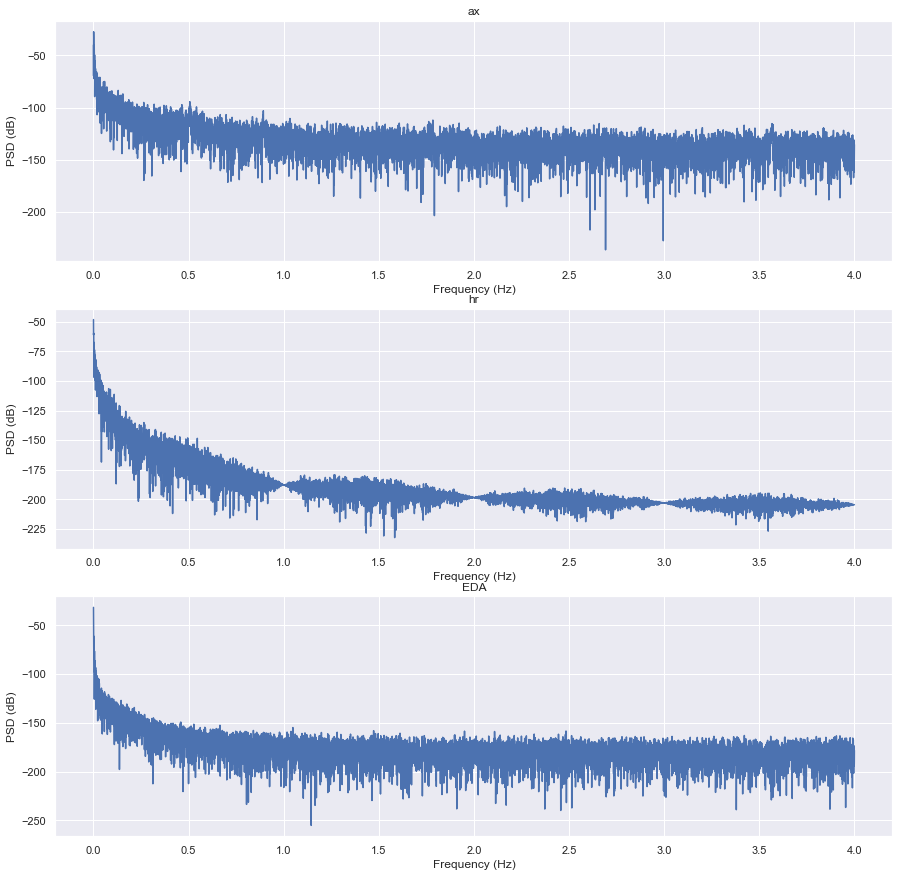

In [50]:
# plot the PSD, focusing only on the positive frequencies
pos_mask = sample_freq > 0

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))

ax1.plot(sample_freq[pos_mask], psd_ax[pos_mask])
ax1.set_title('ax')
ax1.set_ylabel('PSD (dB)')
ax1.set_xlabel('Frequency (Hz)')

ax2.plot(sample_freq[pos_mask], psd_hr[pos_mask])
ax2.set_title('hr')
ax2.set_ylabel('PSD (dB)')
ax2.set_xlabel('Frequency (Hz)')

ax3.plot(sample_freq[pos_mask], psd_eda[pos_mask])
ax3.set_title('EDA')
ax3.set_ylabel('PSD (dB)')
ax3.set_xlabel('Frequency (Hz)')

plt.show()

### Windowing

The above FFTs are very noisy, because we are reading individual samples.

Let's try to apply a window technique to smooth out the samples.

An example is Hamming Window:
https://flothesof.github.io/FFT-window-properties-frequency-analysis.html

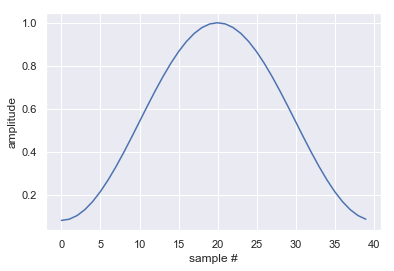

In [51]:
m = samples_per_sec * 5 # window size
w = signal.get_window('hamming', m)

fig, ax = plt.subplots()
ax.plot(w)
ax.set_xlabel('sample #')
ax.set_ylabel('amplitude')
plt.show()

The above is a hamming window of 5 seconds (8 samples per second).

Now, let's apply the windowing function to our signals, and then take the FFT.

Examples:
- https://dsp.stackexchange.com/questions/9465/how-to-apply-hamming-window
- https://stackoverflow.com/questions/44666787/how-to-make-smoother-wave-by-apply-hamming-window

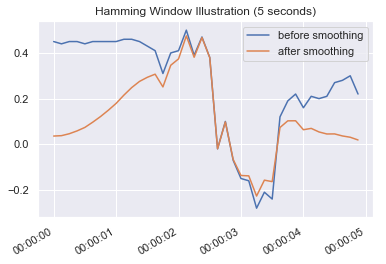

In [52]:
# transform the signal into windows
smoothed_window = df.ax[:m] * w

fig, ax = plt.subplots()
ax.plot(df.ax[:m], label='before smoothing')
ax.plot(smoothed_window, label='after smoothing')
ax.legend()
ax.set_title('Hamming Window Illustration (5 seconds)')
fig.autofmt_xdate()

plt.show()

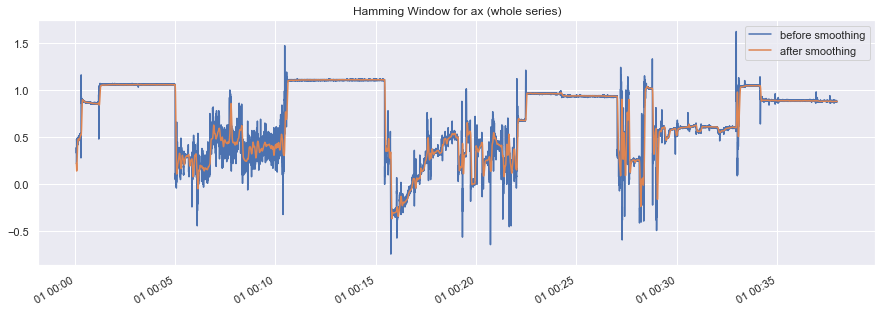

In [53]:
# Apply a rolling window transform onto the whole signal
# Pandas has a nice "rolling" function that does a rolling window

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html
df_smoothed = df.rolling(m, win_type='hamming').mean().dropna()

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df.ax[m-1:], label='before smoothing')
ax.plot(df_smoothed.ax, label='after smoothing')
ax.set_title('Hamming Window for ax (whole series)')

fig.autofmt_xdate()
ax.legend()
plt.show()

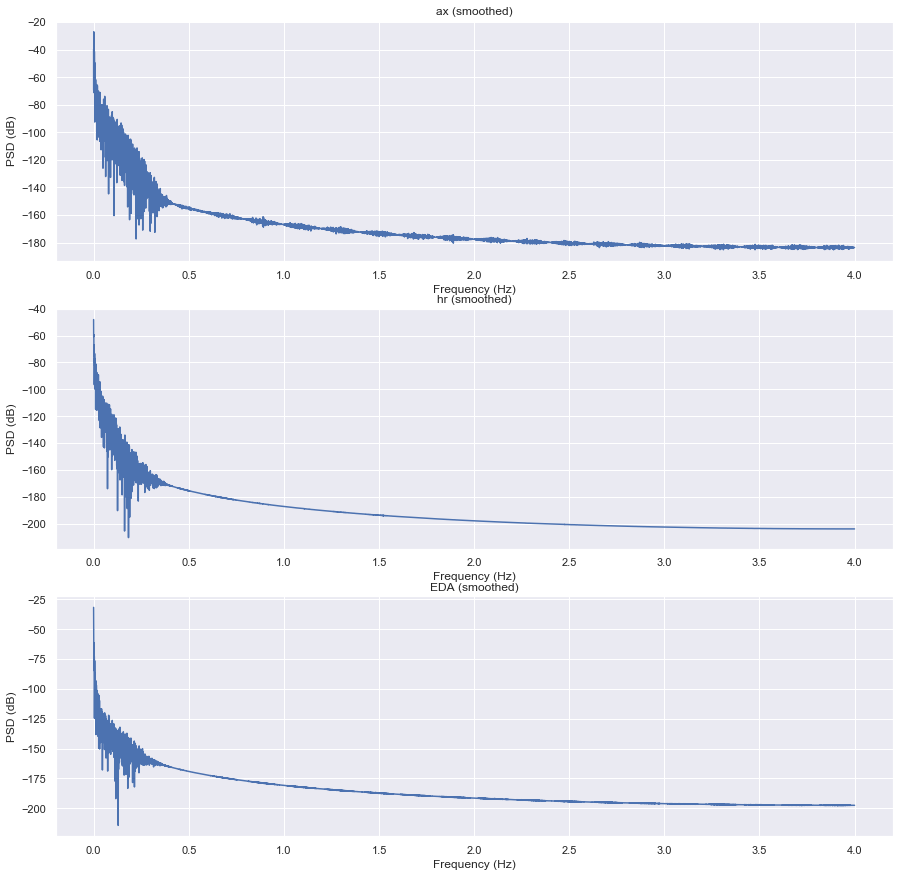

In [54]:
# Recompute FFT

fft_ax = fftpack.fft(df_smoothed.ax)
fft_hr = fftpack.fft(df_smoothed.hr)
fft_eda = fftpack.fft(df_smoothed.EDA)

psd_ax = power_spectral_density(fft_ax)
psd_hr = power_spectral_density(fft_hr)
psd_eda = power_spectral_density(fft_eda)

sample_freq = fftpack.fftfreq(len(df_smoothed.ax), d=1./samples_per_sec)

pos_mask = sample_freq > 0

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))

ax1.plot(sample_freq[pos_mask], psd_ax[pos_mask])
ax1.set_title('ax (smoothed)')
ax1.set_ylabel('PSD (dB)')
ax1.set_xlabel('Frequency (Hz)')

ax2.plot(sample_freq[pos_mask], psd_hr[pos_mask])
ax2.set_title('hr (smoothed)')
ax2.set_ylabel('PSD (dB)')
ax2.set_xlabel('Frequency (Hz)')

ax3.plot(sample_freq[pos_mask], psd_eda[pos_mask])
ax3.set_title('EDA (smoothed)')
ax3.set_ylabel('PSD (dB)')
ax3.set_xlabel('Frequency (Hz)')

plt.show()

## Machine Learning

- Add labels
- Explore features
- Train classification
  - Classification using time-domain signal
  - Classification using frequency-domain features (Examples: https://www.quora.com/How-can-I-use-Fourier-transforms-in-machine-learning, https://s3.amazonaws.com/assets.datacamp.com/production/course_6079/slides/chapter2.pdf)

### Add labels

In [55]:
ann.__dict__

{'record_name': 'Subject10_AccTempEDA',
 'extension': 'atr',
 'sample': array([    1,  2401,  5010,  7411,  7732, 10573, 12974, 15839]),
 'symbol': ['"', '"', '"', '"', '"', '"', '"', '"'],
 'subtype': array([0, 0, 0, 0, 0, 0, 0, 0]),
 'chan': array([0, 0, 0, 0, 0, 0, 0, 0]),
 'num': array([0, 0, 0, 0, 0, 0, 0, 0]),
 'aux_note': ['Relax',
  'PhysicalStress',
  'Relax',
  'EmotionalStress',
  'CognitiveStress',
  'Relax',
  'EmotionalStress',
  'Relax'],
 'fs': 8,
 'label_store': None,
 'description': None,
 'custom_labels': None,
 'contained_labels':     label_store symbol         description
 22           22      "  Comment annotation,
 'ann_len': 8}

In [56]:
# Add labels to the original data
ann.sample

array([    1,  2401,  5010,  7411,  7732, 10573, 12974, 15839])

In [57]:
ann.aux_note

['Relax',
 'PhysicalStress',
 'Relax',
 'EmotionalStress',
 'CognitiveStress',
 'Relax',
 'EmotionalStress',
 'Relax']

In [58]:
# indices are 0-based
start = ann.sample - 1
end = ann.sample[1:] - 1
end[-1] = -1 # last element

print('start indices', start)
print('end indices', end)

start indices [    0  2400  5009  7410  7731 10572 12973 15838]
end indices [ 2400  5009  7410  7731 10572 12973    -1]


In [59]:
df['label'] = ''

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18239 entries, 2019-01-01 00:00:00 to 2019-01-01 00:37:59.750000
Freq: 125L
Data columns (total 11 columns):
ax        18239 non-null float64
ay        18239 non-null float64
az        18239 non-null float64
temp      18239 non-null float64
EDA       18239 non-null float64
SpO2      18239 non-null float64
hr        18239 non-null float64
ax_q10    18239 non-null int64
ay_q10    18239 non-null int64
az_q10    18239 non-null int64
label     18239 non-null object
dtypes: float64(7), int64(3), object(1)
memory usage: 2.3+ MB


In [61]:
for s, e, label in zip(start, end, ann.aux_note):
    print(s, e, label) # s is inclusive, e is exclusive
    df.label[s:e] = label # we'll get a SettingWithCopyWarning but it's actually okay to ignore (1 level indirection)

0 2400 Relax
2400 5009 PhysicalStress
5009 7410 Relax
7410 7731 EmotionalStress
7731 10572 CognitiveStress
10572 12973 Relax
12973 -1 EmotionalStress


C:\Users\issohl\AppData\Local\conda\conda\envs\hss\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [62]:
df.label[-1] = df.label[-2] # we'll get a SettingWithCopyWarning but it's actually okay to ignore (1 level indirection)

C:\Users\issohl\AppData\Local\conda\conda\envs\hss\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [63]:
df.tail()

,ax,ay,az,temp,EDA,SpO2,hr,ax_q10,ay_q10,az_q10,label
2019-01-01 00:37:59.250,0.879985,-0.74998,-0.020002,33.499966,6.225915,95.999939,74.000351,5,2,5,EmotionalStress
2019-01-01 00:37:59.375,0.879985,-0.74998,-0.020002,33.499966,6.278996,95.999939,74.000351,5,2,5,EmotionalStress
2019-01-01 00:37:59.500,0.879985,-0.74998,-0.020002,33.499966,6.225915,95.999939,74.000351,5,2,5,EmotionalStress
2019-01-01 00:37:59.625,0.879985,-0.74998,-0.020002,33.499966,6.225915,95.999939,74.000351,5,2,5,EmotionalStress
2019-01-01 00:37:59.750,0.879985,-0.74998,-0.020002,33.499966,6.225915,95.999939,74.000351,5,2,5,EmotionalStress


In [64]:
# Label Encode

le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])
df.head()

,ax,ay,az,temp,EDA,SpO2,hr,ax_q10,ay_q10,az_q10,label,label_enc
2019-01-01 00:00:00.000,0.449968,-1.009969,-0.040004,27.000064,3.251014,96.999954,95.999908,2,1,5,Relax,3
2019-01-01 00:00:00.125,0.439993,-1.019987,-0.040004,27.000064,3.256052,96.874952,95.999908,2,0,5,Relax,3
2019-01-01 00:00:00.250,0.449968,-1.019987,-0.050005,27.000064,3.256052,96.749950,95.999908,2,0,5,Relax,3
2019-01-01 00:00:00.375,0.449968,-1.009969,-0.040004,27.000064,3.256052,96.624949,95.999908,2,1,5,Relax,3
2019-01-01 00:00:00.500,0.439993,-1.009969,-0.050005,27.000064,3.256052,96.499947,95.999908,2,1,5,Relax,3


In [65]:
df.corr()

,ax,ay,az,temp,EDA,SpO2,hr,ax_q10,ay_q10,az_q10,label_enc
ax,1.000000,0.362244,0.170707,-0.110856,-0.018944,-0.298530,-0.473594,0.954295,0.294335,0.011857,0.639492
ay,0.362244,1.000000,0.159515,-0.077881,-0.186343,-0.479444,-0.081967,0.383866,0.979013,-0.001496,0.383412
az,0.170707,0.159515,1.000000,0.264251,0.352114,0.246086,-0.661918,0.155289,0.154782,0.844994,-0.220012
temp,-0.110856,-0.077881,0.264251,1.000000,0.695196,0.275015,-0.311503,-0.152813,-0.080247,0.255356,-0.495608
EDA,-0.018944,-0.186343,0.352114,0.695196,1.000000,0.324747,-0.344800,0.042475,-0.168119,0.201379,-0.270410
SpO2,-0.298530,-0.479444,0.246086,0.275015,0.324747,1.000000,-0.113245,-0.324283,-0.447601,0.250082,-0.567175
hr,-0.473594,-0.081967,-0.661918,-0.311503,-0.344800,-0.113245,1.000000,-0.433978,-0.040644,-0.543761,-0.029674
ax_q10,0.954295,0.383866,0.155289,-0.152813,0.042475,-0.324283,-0.433978,1.000000,0.328862,-0.069306,0.674316
ay_q10,0.294335,0.979013,0.154782,-0.080247,-0.168119,-0.447601,-0.040644,0.328862,1.000000,-0.025101,0.332204
az_q10,0.011857,-0.001496,0.844994,0.255356,0.201379,0.250082,-0.543761,-0.069306,-0.025101,1.000000,-0.266378


### Train-test split

Hold out a portion of the dataset for testing. 

Alternatively, we can get the data from another person, but risk more variability that is not explained by the features.

In [66]:
df_train, df_test = train_test_split(df, random_state=42) # randomise features the same way each time (repeatability)

### Feature Selection

Select K-best features based on correlation-like test.

In [67]:
candidate_features = df.columns.drop(['label', 'label_enc'])
candidate_features

Index(['ax', 'ay', 'az', 'temp', 'EDA', 'SpO2', 'hr', 'ax_q10', 'ay_q10',
       'az_q10'],
      dtype='object')

In [68]:
kbest = SelectKBest(k=5, score_func=f_classif)
kbest.fit(df_train.loc[:, candidate_features], df_train.label_enc)

kbest.scores_

array([7432.30149294, 2804.55208099, 8076.68042407, 2552.06267538,
       1945.75423112, 3891.56997021, 9712.49873549, 9360.99952343,
       2094.01923366, 3422.02957614])

In [69]:
# best 5 features
candidate_features[kbest.get_support()]

Index(['ax', 'az', 'SpO2', 'hr', 'ax_q10'], dtype='object')

In [70]:
X_train = kbest.transform(df_train.loc[:, candidate_features])
X_test = kbest.transform(df_test.loc[:, candidate_features])
y_train = df_train.label_enc
y_test = df_test.label_enc

## Bayes classifier

Uses Bayes Theorem and counting to compute conditional probability of each type of event.

The probabilities are modeled using the gaussian probability distribution function.

This is a good "starter" model because it is simple and interpretable.

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

In [71]:
nb = GaussianNB()
nb.fit(X_train, y_train)
print('Accuracy', nb.score(X_test, y_test))

Accuracy 0.7708333333333334


                 precision    recall  f1-score   support

CognitiveStress       0.78      0.94      0.85       716
EmotionalStress       0.72      0.44      0.55      1384
 PhysicalStress       0.99      0.98      0.98       661
          Relax       0.72      0.88      0.79      1799

      micro avg       0.77      0.77      0.77      4560
      macro avg       0.80      0.81      0.79      4560
   weighted avg       0.77      0.77      0.76      4560



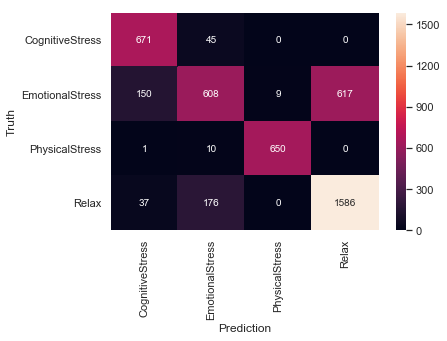

In [72]:
pred_nb = nb.predict(X_test)
print(classification_report(y_test, pred_nb, target_names=le.classes_))

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, pred_nb), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
ax.set_xlabel('Prediction')
ax.set_ylabel('Truth')
plt.show()

## Random Forest Classifier

A Naive Bayes model doesn't really support tuning.  Let's try an ensemble algorithm such as Random Forest.

This creates a number of decision tree classifiers on subsets of the dataset, and averages the results.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [73]:
# max_depth and n_estimators limit overfitting
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

rf.fit(X_train, y_train)
rf.score(X_test, y_test)

print('Accuracy', rf.score(X_test, y_test))

Accuracy 0.9462719298245614


                 precision    recall  f1-score   support

CognitiveStress       0.85      0.98      0.91       716
EmotionalStress       0.93      0.91      0.92      1384
 PhysicalStress       0.99      0.99      0.99       661
          Relax       0.99      0.94      0.96      1799

      micro avg       0.95      0.95      0.95      4560
      macro avg       0.94      0.96      0.95      4560
   weighted avg       0.95      0.95      0.95      4560



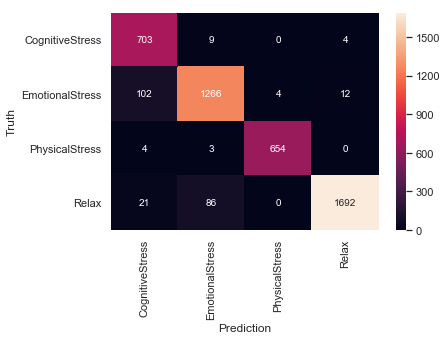

In [74]:
pred_rf = rf.predict(X_test)
print(classification_report(y_test, pred_rf, target_names=le.classes_))

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, pred_rf), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
ax.set_xlabel('Prediction')
ax.set_ylabel('Truth')
plt.show()

## Tuning

We can perform a grid search on combinations of RandomForest hyperparameters to find a better model.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [75]:
param_grid = {
    'max_depth': [3, 5, 7, 9, 11, 13, 15],
    'n_estimators': [75, 100, 125, 150, 175, 200, 225]
}

# Run 4 jobs concurrently
gs = GridSearchCV(rf, param_grid, n_jobs=4, cv=3, verbose=True, return_train_score=True)
gs.fit(X_train, y_train)
print('Accuracy', gs.score(X_test, y_test))
print('Best combination', gs.best_params_)

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:   21.4s finished


Accuracy 0.9888157894736842
Best combination {'max_depth': 15, 'n_estimators': 75}


In [76]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.136968,1.244155e-03,0.007774,1.244155e-03,3,75,"{'max_depth': 3, 'n_estimators': 75}",0.908134,0.908313,0.912481,0.909643,0.002008,43,0.908752,0.912610,0.909430,0.910264,0.001682
1,0.187640,1.130419e-02,0.026382,3.461380e-03,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.908353,0.906339,0.912700,0.909131,0.002654,44,0.908862,0.911294,0.909978,0.910045,0.000994
2,0.233855,4.567220e-03,0.031318,1.038528e-04,3,125,"{'max_depth': 3, 'n_estimators': 125}",0.908353,0.905462,0.909849,0.907888,0.001821,49,0.909300,0.910197,0.907018,0.908838,0.001339
3,0.275808,7.585206e-03,0.031245,2.697398e-06,3,150,"{'max_depth': 3, 'n_estimators': 150}",0.908353,0.905681,0.909849,0.907961,0.001724,48,0.909300,0.909978,0.906908,0.908729,0.001317
4,0.334367,1.643730e-02,0.044873,2.816003e-03,3,175,"{'max_depth': 3, 'n_estimators': 175}",0.908353,0.906558,0.909849,0.908254,0.001345,46,0.909410,0.910417,0.906908,0.908912,0.001475
5,0.367396,6.142525e-03,0.056839,1.340227e-02,3,200,"{'max_depth': 3, 'n_estimators': 200}",0.908353,0.906778,0.910726,0.908619,0.001623,45,0.909300,0.910088,0.907346,0.908911,0.001152
6,0.408023,1.059512e-02,0.060569,5.466708e-03,3,225,"{'max_depth': 3, 'n_estimators': 225}",0.908353,0.906558,0.909849,0.908254,0.001345,46,0.909300,0.910197,0.906798,0.908765,0.001438
7,0.169794,3.657303e-03,0.014886,5.272591e-03,5,75,"{'max_depth': 5, 'n_estimators': 75}",0.941022,0.940996,0.950647,0.944221,0.004543,38,0.945821,0.947149,0.945504,0.946158,0.000712
8,0.224120,7.212344e-03,0.026027,7.358124e-03,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.941460,0.941215,0.954157,0.945610,0.006043,36,0.945821,0.947368,0.949232,0.947474,0.001395
9,0.291581,7.350186e-03,0.036450,7.364628e-03,5,125,"{'max_depth': 5, 'n_estimators': 125}",0.940802,0.941435,0.953937,0.945391,0.006048,37,0.945273,0.947149,0.950000,0.947474,0.001943


                 precision    recall  f1-score   support

CognitiveStress       0.98      0.98      0.98       716
EmotionalStress       0.98      0.99      0.99      1384
 PhysicalStress       1.00      1.00      1.00       661
          Relax       1.00      0.99      0.99      1799

      micro avg       0.99      0.99      0.99      4560
      macro avg       0.99      0.99      0.99      4560
   weighted avg       0.99      0.99      0.99      4560



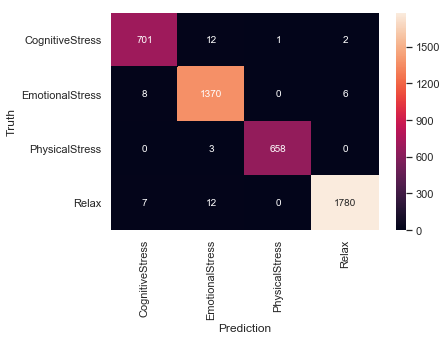

In [77]:
pred_gs = gs.predict(X_test)
print(classification_report(y_test, pred_gs, target_names=le.classes_))

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, pred_gs), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
ax.set_xlabel('Prediction')
ax.set_ylabel('Truth')
plt.show()

## Train using frequency domain features

If time domain features aren't performing well (not really the case here), we can also try using the FFT to fit the model.

1. Take rolling windows of the signal
2. Compute spectral features based on the FFT
3. Use both time-based and spectral features in our model

To learn, we'll be computing the spectral features "by hand", but you can alternatively consider a package like tsfresh that calculates and evaluates the features automatically:
* https://tsfresh.readthedocs.io/en/latest/text/introduction.html
* https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html#tsfresh.feature_extraction.feature_calculators.fft_aggregated


In [78]:
def compute_fft(df, window_size=1, samples_per_sec=8, smoothing=False):
    if smoothing:
        df_ = df.rolling(m, win_type='hamming').mean().dropna()
    else:
        df_ = df
    
    sample_freq_ = fftpack.fftfreq(len(df_), d=1./samples_per_sec)
    pos_mask_ = sample_freq_ > 0
    
    result_df_ = pd.DataFrame(index = sample_freq_[pos_mask_])
    
    # FFT needs to be computed per column, hence we are using a loop
    for c in df_.columns:
        if df_[c].dtype == float:
            fft_ = np.abs(fftpack.fft(df_[c])) # take the magnitude
            result_df_[c + '_fft'] = fft_[pos_mask_]
    
    return result_df_

Since FFT is in the frequency domain, we will need to break up the time signal into time-windows.

Let's say we have time windows of 10 seconds, and we extract FFT characteristics from it.

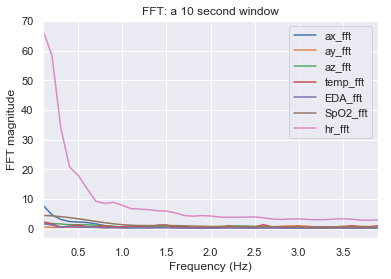

In [79]:
time_window_sec = 10
start_index = 0
end_index = time_window_sec * samples_per_sec

df_time_window = df.iloc[start_index:end_index]
fft_time_window = compute_fft(df_time_window)

fig, ax = plt.subplots()
fft_time_window.plot(ax=ax) # plotting this way adds the correct labels

ax.set_title(f'FFT: a {time_window_sec} second window')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('FFT magnitude')
plt.show()

In [80]:
fft_time_window.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 39 entries, 0.1 to 3.9000000000000004
Data columns (total 7 columns):
ax_fft      39 non-null float64
ay_fft      39 non-null float64
az_fft      39 non-null float64
temp_fft    39 non-null float64
EDA_fft     39 non-null float64
SpO2_fft    39 non-null float64
hr_fft      39 non-null float64
dtypes: float64(7)
memory usage: 2.4 KB


In [81]:
fft_time_window.max()

ax_fft       7.829464
ay_fft       0.927551
az_fft       1.704144
temp_fft     2.296426
EDA_fft      1.778630
SpO2_fft     4.446346
hr_fft      66.718185
dtype: float64

In [82]:
fft_time_window.min()

ax_fft      0.064002
ay_fft      0.055378
az_fft      0.157182
temp_fft    0.200049
EDA_fft     0.077439
SpO2_fft    0.507413
hr_fft      2.806981
dtype: float64

#### Spectral Centroid

This corresponds to the balancing point or the center of mass of the spectral power distribution.
This value is calculated as the weighted mean of the frequency components present in the signal:

$$\frac{\sum{F(n) \times n}}{\sum F(n)}$$

In [83]:
# Spectral centroid is the weighted mean of the frequency components
# fft_time_window.index are the frequencies
spectral_centroid = np.dot(fft_time_window.index, fft_time_window) / np.sum(fft_time_window)

#### Spectral Energy

The equivalent to the energy of the signal as discussed before in
the frequency domain is the spectral energy. This value is computed as the sum of
the squares of the magnitude of the frequency content:

$$\sum{F(n)^2}$$

In [84]:
# Spectral energy

np.sum(fft_time_window ** 2) # sum of squares

ax_fft        117.230099
ay_fft         13.465233
az_fft         24.141792
temp_fft       26.034523
EDA_fft         6.846713
SpO2_fft      117.253578
hr_fft      10765.328534
dtype: float64

#### Spectral Entropy

This refers to the entropy of the signal in the frequency domain. The frequency content of the signal is normalized before the entropy computation.

$$-\sum{\hat{F}(n) \times log(\hat{F}(n))} $$

In [85]:
# normalise the FFT
normalized_fft_time_window = fft_time_window / np.sum(fft_time_window)

# compute entropy
-np.sum(normalized_fft_time_window * np.log(normalized_fft_time_window))

ax_fft      3.025439
ay_fft      3.583320
az_fft      3.492103
temp_fft    3.526712
EDA_fft     3.270150
SpO2_fft    3.361024
hr_fft      3.055795
dtype: float64

### Computing Spectal Features

We'll wrap the computation into a function and then call that function using the pd.DataFrame.rolling() method.

In [86]:
def compute_fft(df, window_size=1, samples_per_sec=8, smoothing=False):
    if smoothing:
        df_ = df.rolling(m, win_type='hamming').mean().dropna()
    else:
        df_ = df
    
    sample_freq_ = fftpack.fftfreq(len(df_), d=1./samples_per_sec)
    pos_mask_ = sample_freq_ > 0
    
    fft_ = np.abs(fftpack.fft(df_))
    result_df_ = pd.Series(index=sample_freq_[pos_mask_], data=fft_[pos_mask_])
    return result_df_

def spectral_centroid(df):
    fft_ = compute_fft(df, window_size=1, samples_per_sec=samples_per_sec, smoothing=False)
    return np.dot(fft_.index, fft_) / np.sum(fft_)

def spectral_energy(df):
    fft_ = compute_fft(df, window_size=1, samples_per_sec=samples_per_sec, smoothing=False)
    return np.sum(fft_ ** 2)

def spectral_entropy(df):
    fft_ = compute_fft(df, window_size=1, samples_per_sec=samples_per_sec, smoothing=False)
    normalized_fft_ = fft_ / np.sum(fft_)
    return -np.sum(normalized_fft_ * np.log(normalized_fft_))

# Example usage:
window_size_secs = 10

# raw = False applies to a pandas Series
# df['ay'].rolling(window_size_secs * samples_per_sec).apply(spectral_centroid, raw=False).dropna().head(10)
# df['ay'].rolling(window_size_secs * samples_per_sec).apply(spectral_energy, raw=False).dropna().head(10)
df['ay'].rolling(window_size_secs * samples_per_sec).apply(spectral_entropy, raw=False).dropna().head(10)

2019-01-01 00:00:09.875    3.583320
2019-01-01 00:00:10.000    3.583374
2019-01-01 00:00:10.125    3.582478
2019-01-01 00:00:10.250    3.582808
2019-01-01 00:00:10.375    3.582808
2019-01-01 00:00:10.500    3.582572
2019-01-01 00:00:10.625    3.582423
2019-01-01 00:00:10.750    3.582423
2019-01-01 00:00:10.875    3.582603
2019-01-01 00:00:11.000    3.582603
Freq: 125L, Name: ay, dtype: float64

In [87]:
float_columns = ['ax', 'ay', 'az', 'temp', 'EDA', 'SpO2', 'hr']

# This can take a while to run... because we do an FFT per column, 3 times
# While groupby supports multiple functions, groupby does not do rolling windows, 
# so we have to call rolling 3 times
for f in float_columns:
    df[f + '_sc'] = df[f].rolling(window_size_secs * samples_per_sec).apply(spectral_centroid, raw=False)
    df[f + '_sen'] = df[f].rolling(window_size_secs * samples_per_sec).apply(spectral_energy, raw=False)
    df[f + '_se'] = df[f].rolling(window_size_secs * samples_per_sec).apply(spectral_entropy, raw=False)

df.dropna(inplace=True)
df.head(10)

,ax,ay,az,temp,EDA,SpO2,hr,ax_q10,ay_q10,az_q10,...,temp_se,EDA_sc,EDA_sen,EDA_se,SpO2_sc,SpO2_sen,SpO2_se,hr_sc,hr_sen,hr_se
2019-01-01 00:00:09.875,0.499988,-1.009969,0.000000,27.400056,3.455063,95.999939,90.124819,3,1,6,...,3.526712,1.182509,6.846713,3.270150,1.204175,1.172536e+02,3.361024,0.964893,10765.328534,3.055795
2019-01-01 00:00:10.000,0.439993,-0.989967,0.009957,27.400056,3.461001,95.999939,89.999817,2,1,7,...,3.545186,1.126998,7.478393,3.239428,1.235085,8.125248e+01,3.389658,0.958255,11821.360762,3.038428
2019-01-01 00:00:10.125,0.430017,-0.989967,0.019958,27.400056,3.461001,95.999939,89.874815,2,1,7,...,3.523494,1.090045,8.056895,3.217817,1.276738,5.336100e+01,3.423469,0.952810,12892.502826,3.019548
2019-01-01 00:00:10.250,0.420006,-0.999985,0.000000,27.400056,3.461001,95.999939,89.749813,2,1,6,...,3.516658,1.096740,8.629681,3.214002,1.326084,3.254787e+01,3.459742,0.949303,13978.473467,3.001510
2019-01-01 00:00:10.375,0.459979,-1.009969,0.000000,27.400056,3.461001,95.999939,89.624811,2,1,6,...,3.521607,1.053712,9.124176,3.171730,1.395763,1.793805e+01,3.503496,0.944879,15077.397629,2.984480
2019-01-01 00:00:10.500,0.439993,-0.999985,0.019958,27.400056,3.461001,95.999939,89.499809,2,1,7,...,3.545663,1.060983,9.612955,3.170191,1.492274,8.437758e+00,3.551373,0.939871,16188.931551,2.973646
2019-01-01 00:00:10.625,0.449968,-0.989967,0.000000,27.400056,3.461001,95.999939,89.374807,2,1,6,...,3.534355,1.022957,10.023442,3.137594,1.644942,3.046968e+00,3.609534,0.932730,17311.075171,2.967367
2019-01-01 00:00:10.750,0.479966,-0.999985,0.029958,27.400056,3.461001,95.999939,89.249805,2,1,7,...,3.456899,1.067783,10.428213,3.156510,2.000000,6.093936e-01,3.663562,0.926109,18443.422228,2.961630
2019-01-01 00:00:10.875,0.459979,-1.019987,0.009957,27.400056,3.461001,95.999939,89.124804,2,0,7,...,3.451079,1.026728,10.719342,3.105919,0.974856,1.033976e-25,2.894143,0.916323,19583.847656,2.956597
2019-01-01 00:00:11.000,0.459979,-1.009969,0.009957,27.400056,3.461001,95.999939,88.999802,2,1,7,...,3.452934,1.056626,11.040105,3.102408,0.974856,1.033976e-25,2.894143,0.919883,20731.882692,2.962953


In [88]:
# move the label column to the front so that it is easy to see
new_cols = ['label', 'label_enc'] + df.columns.drop(['label', 'label_enc']).tolist()

df = df[new_cols]
df.head()

,label,label_enc,ax,ay,az,temp,EDA,SpO2,hr,ax_q10,...,temp_se,EDA_sc,EDA_sen,EDA_se,SpO2_sc,SpO2_sen,SpO2_se,hr_sc,hr_sen,hr_se
2019-01-01 00:00:09.875,Relax,3,0.499988,-1.009969,0.000000,27.400056,3.455063,95.999939,90.124819,3,...,3.526712,1.182509,6.846713,3.270150,1.204175,117.253578,3.361024,0.964893,10765.328534,3.055795
2019-01-01 00:00:10.000,Relax,3,0.439993,-0.989967,0.009957,27.400056,3.461001,95.999939,89.999817,2,...,3.545186,1.126998,7.478393,3.239428,1.235085,81.252480,3.389658,0.958255,11821.360762,3.038428
2019-01-01 00:00:10.125,Relax,3,0.430017,-0.989967,0.019958,27.400056,3.461001,95.999939,89.874815,2,...,3.523494,1.090045,8.056895,3.217817,1.276738,53.361003,3.423469,0.952810,12892.502826,3.019548
2019-01-01 00:00:10.250,Relax,3,0.420006,-0.999985,0.000000,27.400056,3.461001,95.999939,89.749813,2,...,3.516658,1.096740,8.629681,3.214002,1.326084,32.547868,3.459742,0.949303,13978.473467,3.001510
2019-01-01 00:00:10.375,Relax,3,0.459979,-1.009969,0.000000,27.400056,3.461001,95.999939,89.624811,2,...,3.521607,1.053712,9.124176,3.171730,1.395763,17.938047,3.503496,0.944879,15077.397629,2.984480


In [89]:
df.corr()

,label_enc,ax,ay,az,temp,EDA,SpO2,hr,ax_q10,ay_q10,...,temp_se,EDA_sc,EDA_sen,EDA_se,SpO2_sc,SpO2_sen,SpO2_se,hr_sc,hr_sen,hr_se
label_enc,1.000000,0.505683,0.374446,-0.232245,-0.425449,-0.423455,-0.482825,-0.028835,0.536439,0.316901,...,0.147910,-0.161777,0.129680,-0.196932,0.066429,0.124563,0.080049,0.051005,0.019532,0.055084
ax,0.505683,1.000000,0.294549,0.183920,0.100505,-0.104488,-0.167622,-0.494402,0.951909,0.212068,...,0.295079,0.364863,-0.003601,0.323715,0.055449,-0.075771,0.042283,-0.066639,0.060636,-0.046256
ay,0.374446,0.294549,1.000000,0.153036,-0.029721,-0.364673,-0.448799,-0.041065,0.298834,0.978063,...,0.159064,-0.096985,-0.027548,-0.137262,0.060331,0.029077,0.061527,0.069637,0.096098,0.076603
az,-0.232245,0.183920,0.153036,1.000000,0.306669,0.391689,0.182303,-0.564912,0.193455,0.145849,...,0.064356,0.517016,-0.066302,0.525007,-0.014376,-0.220936,-0.053719,-0.123223,-0.133590,-0.099282
temp,-0.425449,0.100505,-0.029721,0.306669,1.000000,0.668327,0.158698,-0.356637,0.093179,-0.045578,...,0.177458,0.535751,-0.074777,0.500385,0.061846,-0.156867,0.054859,-0.091419,-0.036085,-0.076228
EDA,-0.423455,-0.104488,-0.364673,0.391689,0.668327,1.000000,0.375117,-0.190975,-0.029752,-0.332486,...,0.010101,0.503733,0.038126,0.541137,-0.017505,-0.097379,-0.029917,-0.140875,-0.030085,-0.133370
SpO2,-0.482825,-0.167622,-0.448799,0.182303,0.158698,0.375117,1.000000,-0.021973,-0.178346,-0.417213,...,-0.061646,0.191916,-0.049788,0.201575,-0.053280,0.023377,-0.073321,-0.090720,0.167776,-0.077942
hr,-0.028835,-0.494402,-0.041065,-0.564912,-0.356637,-0.190975,-0.021973,1.000000,-0.474868,0.017480,...,-0.148278,-0.640607,0.231075,-0.609013,-0.010133,0.284958,0.021411,0.170978,0.235073,0.138455
ax_q10,0.536439,0.951909,0.298834,0.193455,0.093179,-0.029752,-0.178346,-0.474868,1.000000,0.222780,...,0.243116,0.389387,0.002112,0.354531,0.063834,-0.086621,0.052275,-0.059667,0.085116,-0.037771
ay_q10,0.316901,0.212068,0.978063,0.145849,-0.045578,-0.332486,-0.417213,0.017480,0.222780,1.000000,...,0.137379,-0.137656,-0.025032,-0.170552,0.061709,0.040925,0.065712,0.079216,0.095783,0.083397


#### K-best Feature selection

In [90]:
df_train, df_test = train_test_split(df, random_state=42)

X_train = df_train[df.columns.drop(['label', 'label_enc'])]
X_test = df_test[df.columns.drop(['label', 'label_enc'])]

y_train = df_train['label_enc']
y_test = df_test['label_enc']

kbest = SelectKBest(k=8, score_func=f_classif)
kbest.fit(X_train, y_train)

X_train.columns[kbest.get_support()]

Index(['ax', 'ay', 'az', 'EDA', 'hr', 'ax_q10', 'EDA_sc', 'EDA_se'], dtype='object')

In [91]:
# drop ax_q10 since it is derived from ax (collinear features are problematic for convergence of some algorithms)

X_train = df_train[df.columns.drop(['label', 'label_enc', 'ax_q10', 'ay_q10', 'az_q10'])]
X_test = df_test[df.columns.drop(['label', 'label_enc', 'ax_q10', 'ay_q10', 'az_q10'])]

y_train = df_train['label_enc']
y_test = df_test['label_enc']

In [92]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Retrain Model

In [93]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb.score(X_test, y_test)

0.7934826883910387

                 precision    recall  f1-score   support

CognitiveStress       0.75      0.92      0.82       641
EmotionalStress       0.78      0.87      0.82      1020
 PhysicalStress       0.90      0.95      0.92       315
          Relax       0.90      0.36      0.51       479

      micro avg       0.79      0.79      0.79      2455
      macro avg       0.83      0.77      0.77      2455
   weighted avg       0.81      0.79      0.77      2455



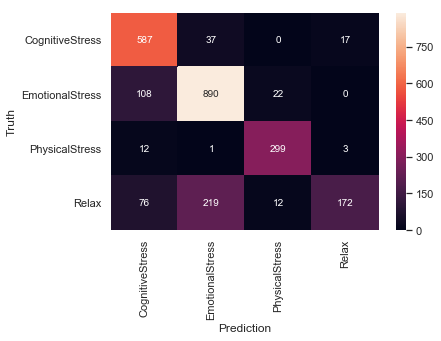

In [94]:
pred_nb = nb.predict(X_test)
print(classification_report(y_test, pred_nb, target_names=le.classes_))

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, pred_nb), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
ax.set_xlabel('Prediction')
ax.set_ylabel('Truth')
plt.show()

The Naive Bayes classifier performed slightly better overall with spectral features.

Inclusion of spectral features reduced the ability of the classifier to distinguish "Relax" and "EmotionalStress". It mistakenly predicted more cases of "Relax" as "EmotionalStress" (0.36 recall, with 219 errors). 

Without spectral features:
```
                 precision    recall  f1-score   support

CognitiveStress       0.78      0.94      0.85       716
EmotionalStress       0.72      0.44      0.55      1384
 PhysicalStress       0.99      0.98      0.98       661
          Relax       0.72      0.88      0.79      1799

      micro avg       0.77      0.77      0.77      4560
      macro avg       0.80      0.81      0.79      4560
   weighted avg       0.77      0.77      0.76      4560
```

With spectral features (FFT window length 10s):
```
                 precision    recall  f1-score   support

CognitiveStress       0.75      0.92      0.82       641
EmotionalStress       0.78      0.87      0.82      1020
 PhysicalStress       0.90      0.95      0.92       315
          Relax       0.90      0.36      0.51       479

      micro avg       0.79      0.79      0.79      2455
      macro avg       0.83      0.77      0.77      2455
   weighted avg       0.81      0.79      0.77      2455

```

In [95]:
param_grid = {
    'max_depth': [3, 5, 7, 9, 11, 13, 15],
    'n_estimators': [75, 100, 125, 150, 175, 200, 225]
}

# Run 4 jobs concurrently
gs = GridSearchCV(rf, param_grid, n_jobs=4, cv=3, verbose=True, return_train_score=True)
gs.fit(X_train, y_train)
print('Accuracy', gs.score(X_test, y_test))
print('Best combination', gs.best_params_)

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:   34.0s finished


Accuracy 0.9987780040733197
Best combination {'max_depth': 11, 'n_estimators': 75}


                 precision    recall  f1-score   support

CognitiveStress       1.00      1.00      1.00       641
EmotionalStress       1.00      1.00      1.00      1020
 PhysicalStress       1.00      1.00      1.00       315
          Relax       1.00      1.00      1.00       479

      micro avg       1.00      1.00      1.00      2455
      macro avg       1.00      1.00      1.00      2455
   weighted avg       1.00      1.00      1.00      2455



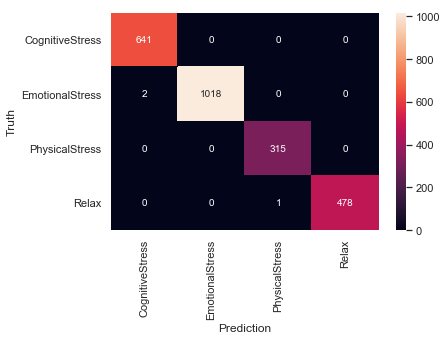

In [96]:
pred_gs = gs.predict(X_test)
print(classification_report(y_test, pred_gs, target_names=le.classes_))

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, pred_gs), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
ax.set_xlabel('Prediction')
ax.set_ylabel('Truth')
plt.show()

The RandomForest classifier performed almost perfectly with Spectral Features.  It was able to use the additional spectral features to correctly identify all but 3 cases.  It had no trouble distinguishing between the "Relax" and "EmotionalStress" categories, for example.

Without spectral features:
```
                 precision    recall  f1-score   support

CognitiveStress       0.98      0.98      0.98       716
EmotionalStress       0.98      0.99      0.99      1384
 PhysicalStress       1.00      1.00      1.00       661
          Relax       1.00      0.99      0.99      1799

      micro avg       0.99      0.99      0.99      4560
      macro avg       0.99      0.99      0.99      4560
   weighted avg       0.99      0.99      0.99      4560
```

With spectral features (FFT window length 10s):
```
                 precision    recall  f1-score   support

CognitiveStress       1.00      1.00      1.00       641
EmotionalStress       1.00      1.00      1.00      1020
 PhysicalStress       1.00      1.00      1.00       315
          Relax       1.00      1.00      1.00       479

      micro avg       1.00      1.00      1.00      2455
      macro avg       1.00      1.00      1.00      2455
   weighted avg       1.00      1.00      1.00      2455
```

### Decision Boundaries

(You can never be done with analysis).

Let's see if we can compare the decision boundaries, to get a better sense of how the features are spread out.

1. Perform 2-D PCA
2. Create a mesh grid, colour regions based on predictions from the classifier
3. Repeat step 2 for each classifier